In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
transform_train = transforms.Compose([
              transforms.RandomResizedCrop(224),
              transforms.ToTensor(),
              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
transform_test = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
num_classes = 10
batch_size =4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=True)

In [9]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
7


In [0]:
#print(labels)

In [10]:
print(batch_size)

4


In [0]:
def imshow(img, title):
  npimg = img.numpy() /2 + 0.5
  plt.figure(figsize=(batch_size,1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.title(title)
  plt.show()

In [0]:
def show_batch_images(dataloader):
  images,labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])


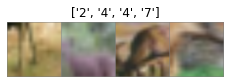

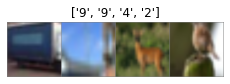

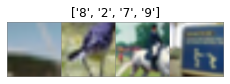

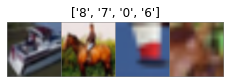

In [13]:
for i in range(4):
  show_batch_images(trainloader)

https://pytorch.org/docs/master/_modules/torchvision/models/vgg.html

In [0]:
from torchvision import models

In [0]:
vgg = models.vgg16_bn()

In [15]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [16]:
print(vgg.features[39])

ReLU(inplace=True)


In [17]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [0]:
#TO convert the VGG model's last layer, we need to change the model itself by extending the
#List classfier

In [18]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [19]:
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [20]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


Training CIFAR 10

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle = False)

In [0]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, pred = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (pred == labels).sum().item()
    return 100*correct/total

In [0]:
vgg =vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [0]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)
for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        del inputs, labels, outputs
        torch.cuda.empty_cache()

        if i%100 ==0:
            print('Iteration: %d %d, Loss: %0.2f' % (i, n_iters, loss.item()))
    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train accL %0.2f' %(epoch, max_epochs,
                                                                      evaluation(testloader, vgg),
                                                                      evaluation(trainloader,vgg)))
plt.plot(loss_epoch_arr)
plt.show()

Freeze Layers of Convolutional Operations

In [0]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [27]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
for param in vgg.parameters():
  param.requires_grad = False

In [0]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [31]:
for param in vgg.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr =0.05)

In [0]:
loss_epoch_arr = []
max_epochs = 1
n_iters = np.ceil(50000/batch_size)
for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        if i % 100 ==0:
            print('Iteration %d/%d, Loss: %0.2f'%(i,n_iters, loss.item()))

        del inputs, labels, outputs
        torch.cuda.empty_cache()

    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f'%(
        epoch, max_epochs, evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
plt.plot(loss_epoch_arr)
plt.show()


With Model Copies

In [0]:
import copy

In [0]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min Loss %0.2f' %min_loss)

        if i % 100 == 0:
            print('Iteration : %d/%d, Loss: %0.2f' %(i, n_iters, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())



Min Loss 0.90
Iteration : 0/3125, Loss: 0.90
Min Loss 0.64
Iteration : 100/3125, Loss: 2.02
Iteration : 200/3125, Loss: 1.79
Iteration : 300/3125, Loss: 2.34
Iteration : 400/3125, Loss: 1.96
Iteration : 500/3125, Loss: 1.32
Iteration : 600/3125, Loss: 1.48
Iteration : 700/3125, Loss: 1.89
Min Loss 0.59
Iteration : 800/3125, Loss: 2.01
Iteration : 900/3125, Loss: 2.61
Iteration : 1000/3125, Loss: 1.41
Iteration : 1100/3125, Loss: 3.44
Iteration : 1200/3125, Loss: 2.36
Iteration : 1300/3125, Loss: 1.64
Iteration : 1400/3125, Loss: 2.58
Iteration : 1500/3125, Loss: 2.34
Iteration : 1600/3125, Loss: 2.83
Iteration : 1700/3125, Loss: 2.98
Iteration : 1800/3125, Loss: 2.96
Iteration : 1900/3125, Loss: 2.30
Iteration : 2000/3125, Loss: 2.37


In [0]:
vgg.load_state_dict(best_model)
print(evaluatoin(trainloader, vgg), evaluation(testloader, vgg))

Freeze layers of Convolutional Operations

In [0]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [27]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
for param in vgg.parameters():
    param.requires_grad = False

In [0]:
final_in_feature = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [30]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.44
Iteration: 100/3125, Loss: 1.76
Iteration: 200/3125, Loss: 1.41
Iteration: 300/3125, Loss: 2.80
Iteration: 400/3125, Loss: 2.12
Iteration: 500/3125, Loss: 1.57
Iteration: 600/3125, Loss: 2.25
Iteration: 700/3125, Loss: 1.76
Iteration: 800/3125, Loss: 3.35
Iteration: 900/3125, Loss: 2.11
Iteration: 1000/3125, Loss: 1.75
Iteration: 1100/3125, Loss: 1.26
Iteration: 1200/3125, Loss: 1.62
Iteration: 1300/3125, Loss: 1.52
Iteration: 1400/3125, Loss: 2.39
Iteration: 1500/3125, Loss: 2.70
Iteration: 1600/3125, Loss: 2.57
Iteration: 1700/3125, Loss: 1.94
Iteration: 1800/3125, Loss: 2.10
Iteration: 1900/3125, Loss: 1.23
Iteration: 2000/3125, Loss: 2.02
Iteration: 2100/3125, Loss: 1.47
Iteration: 2200/3125, Loss: 1.95
Iteration: 2300/3125, Loss: 2.81
Iteration: 2400/3125, Loss: 1.53
Iteration: 2500/3125, Loss: 1.95
Iteration: 2600/3125, Loss: 2.48
Iteration: 2700/3125, Loss: 1.02
Iteration: 2800/3125, Loss: 1.76
Iteration: 2900/3125, Loss: 1.50
Iteration: 3000/3125, 

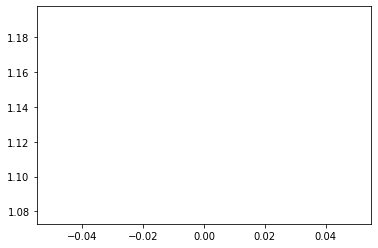

In [33]:
loss_epoch_arr =[]
max_epochs =1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        if i%100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' %(i, n_iters, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()

    loss_epoch_arr.append(loss.item())

    print("Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f" %(epoch, max_epochs,
                                                              evaluation(testloader, vgg),
                                                              evaluation(trainloader, vgg)))
    
plt.plot(loss_epoch_arr)
plt.show()


ResNet Model

In [34]:
resnet = models.resnet18(pretrained= True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [35]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in resnet.parameters():
    param.requires_grad = False

In [0]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [38]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.01)

In [42]:
loss_epoch_arr=[]
min_loss_arr = []
max_epochs = 1

min_loss =1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        if min_loss>loss.item():
            min_loss = loss.item()
            min_loss_arr.append(min_loss)
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' %min_loss)

        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' %(i, n_iters, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()

    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f'%(epoch, max_epochs,
                                                             evaluation(testloader, resnet),
                                                             evaluation(trainloader, resnet)))
plt.plot(loss_epoch_arr)
plt.show()

NameError: ignored

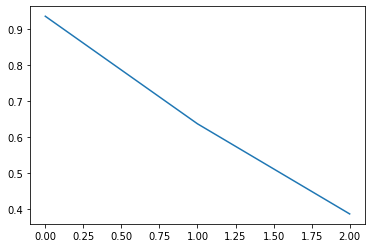

In [44]:
plt.plot(min_loss_arr)
plt.show()

# SqueezeNet Model

In [20]:
sq = models.squeezenet1_1(pretrained=True)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth


In [21]:
print(sq)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [0]:
for param in sq.parameters():
    param.requires_grad = False

In [23]:
in_features = sq.classifier[1].in_channels
out_features = sq.classifier[1].out_channels
features = list(sq.classifier.children())
print(features)

[Dropout(p=0.5, inplace=False), Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1)), ReLU(inplace=True), AdaptiveAvgPool2d(output_size=(1, 1))]


In [0]:
features[1] = nn.Conv2d(in_features, 10, kernel_size=(1, 1), stride=(1, 1))

In [0]:
features[3]= nn.AvgPool2d(10, stride=1)


In [0]:
sq.classifier = nn.Sequential(*features)

In [0]:
sq.num_classes = 10

In [28]:
print(sq.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AvgPool2d(kernel_size=10, stride=1, padding=0)
)


In [29]:
for param in sq.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512, 1, 1])
torch.Size([10])


In [0]:
sq = sq.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(sq.parameters(), lr=0.01)

In [0]:
for param in sq.parameters():
    print(param.shape)

In [44]:
loss_epoch_arr = []
max_epochs = 4
min_loss = 1000
loss_arr = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = sq(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        if min_loss>loss.item():
            min_loss=loss.item()
            best_model = copy.deepcopy(sq.state_dict())
            print('Min Loss %0.2f'% min_loss)
            loss_arr.append(min_loss)

        if i%100 ==0:
            print('Iteration: %d/%d, Loss: %0.2f' %(i, n_iters, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()

    loss_epoch_arr.append(loss.item())

    print('Epoch; %d/%d, Test acc: %0.2f, Train acc: %0.2f' %(
        epoch, max_epochs, evaluation(testloader, sq)))
    


Min Loss 2.28
Iteration: 0/3125, Loss: 2.28
Min Loss 2.22
Min Loss 2.22
Min Loss 2.15
Iteration: 100/3125, Loss: 2.52
Min Loss 2.14
Min Loss 2.12
Iteration: 200/3125, Loss: 2.65
Min Loss 2.08
Iteration: 300/3125, Loss: 2.56
Iteration: 400/3125, Loss: 2.46
Min Loss 2.06
Iteration: 500/3125, Loss: 2.62
Min Loss 1.96
Iteration: 600/3125, Loss: 2.39
Iteration: 700/3125, Loss: 2.58
Iteration: 800/3125, Loss: 2.69
Iteration: 900/3125, Loss: 2.90
Iteration: 1000/3125, Loss: 2.27
Iteration: 1100/3125, Loss: 2.79
Iteration: 1200/3125, Loss: 2.55
Iteration: 1300/3125, Loss: 2.27
Iteration: 1400/3125, Loss: 2.88
Iteration: 1500/3125, Loss: 2.52
Iteration: 1600/3125, Loss: 2.83
Iteration: 1700/3125, Loss: 2.55
Iteration: 1800/3125, Loss: 2.81
Iteration: 1900/3125, Loss: 2.37
Iteration: 2000/3125, Loss: 2.63
Iteration: 2100/3125, Loss: 2.43
Iteration: 2200/3125, Loss: 2.37
Iteration: 2300/3125, Loss: 2.52
Iteration: 2400/3125, Loss: 2.42
Iteration: 2500/3125, Loss: 2.57
Iteration: 2600/3125, Loss: 

TypeError: ignored

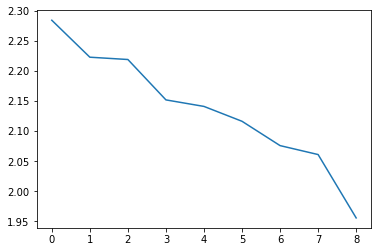

In [45]:
plt.plot(loss_arr)
plt.show()

In [0]:
sq.load_state_dict(best_model)
print(evaluation(trainloader, sq), evaluation(testloader, sq))